## Approach

1.  load dataset remove the data without 'default' column and name it as test and use the remaining data and name is as 'train'
2.  Exploratory Data Analytics
    * Plot % of NaN data per column
    * Visualizing Column Data Distribution for Numerical Columns

<p>&nbsp;</p>

3. Understanding Features
    * Dealing with NaN values:
        * Bar graphs for visualizing probability distribution for categorical columns with Nans
        * selecting mode for filling NaNs and reasoning behind the decision was very high frequency of mode relative to data
        * selecting  mean for other numerical columns 
        <p>&nbsp;</p>
    * Dealing with categorical columns
        * strategy 1: Cols with less than or equal to 5 unique features we will go with label encoding and rest with one hot encoding (Advantage and Disadvantages)

        * Strategy 2: all categorical cols will have one hot encoding, especially relevant when using XGBOOST
    

<p>&nbsp;</p>

4. Feature Exploration:
    (wetting the possibility of dimensionality reduction by exploring feature importance)
    * feature importance using Shapely Additive Explanations (ShAP)  


<p>&nbsp;</p>
    
5. Training
               
    * Deal with Imbalanced data by using combination of SMOTE- ENN (Synthetic Minority Oversampling Technique)-(Edited Nearest Neighbor)
    
    * Dimensionality Reduction: For convenience of training 5 categorical and 5 numerical features are used
    * Model Training (XGBOOST)
    * Analyse the results
    * Take all the code above and create functions to make it all in one file and make a Flask app or Fast API APP
    * Test the app in local environment
    * Make a Docker Container
    * set up ECR in AWS and do the deployement



6. Extras, Discussion and Ideas for Future Work

    * Understanding Risk Budgetting
    * feature importance using Principal Component Analysis (Future Work)
    * Algorithm Optimization








In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

df = pd.read_csv('C:\Tests\Klarna\klarna\dataset.csv', sep=';')
test = df[df['default'].isna()]



<h1> Exploratory Data Analytics </h2>

Observations:

* It is an Imbalanced dataset as expected as most people do not default and only few default, from the train dataset we have 88688 users (98.56%) with default:0 and 1288 users (1.43%) with default:1 and total of 89976.

* In total 43 columns, with 1 unique id ('uuid') for every customer which is text, 1 target column ('default') categorical and  15 categorical columns , 25 numerical columns and 1 boolean column

* Several columns with missing value data, here is the list with corresponding percentage of missing values: missing_value_columns.txt

>for example some columns such as 'account_worst_status_3_6m' has around 57% missing values, 'account_worst_status_12_24m' has 66% and the entire list can be obtained in the txt file 'missing_value_columns.txt'

>train is the data with non-zero 'default' column as this is the only data that we can train on but note that for actually training we will use a subset of this data to do the validation and testing

In [40]:
train = df[~df['default'].isna()]

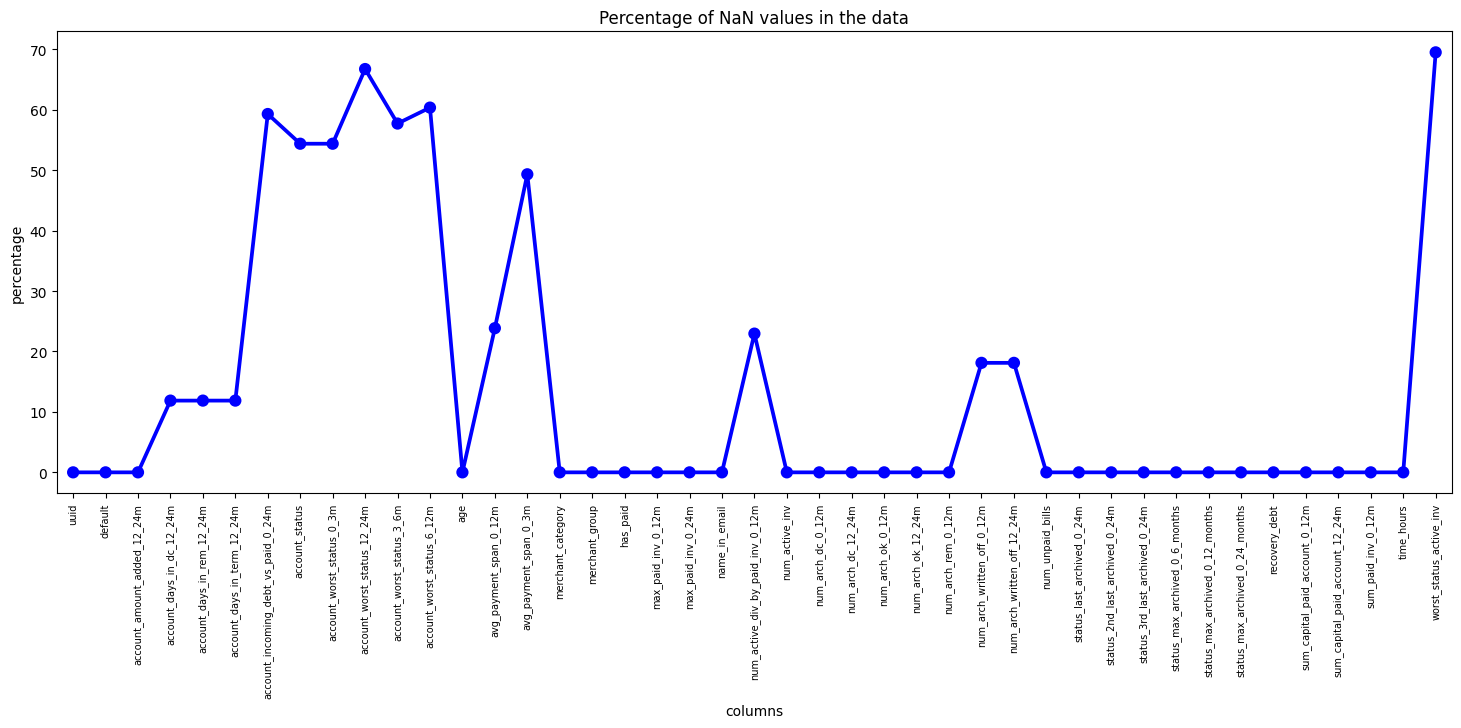

In [7]:
def plot_NaN_data(df):
    '''
    A function to compute the percentage of NaN points per column

    INPUT: dataframe with several columns

    OUTPUT: dataframe with column and the corresponding percentage of NaN points in that column
    '''
    fig = plt.figure(figsize=(18,6))
    all_nans = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
    ax = sns.pointplot(x='index', y=0, data= all_nans,  color='blue'); 
    plt.xticks(rotation=90, fontsize=7)
    plt.title('Percentage of NaN values in the data')
    plt.ylabel('percentage')
    plt.xlabel('columns')
    ax.set_facecolor('white')
    fig.set_facecolor('white')
    return all_nans

all_nans = plot_NaN_data(train)

# print(all_nans)


<h2> Visualizing Column data distribution </h2>

> Note that temporary_train has both numeric as well as categorical columns except for object and string type columns, the idea was to create bar graphs for as many columns as possible to see the data distribution

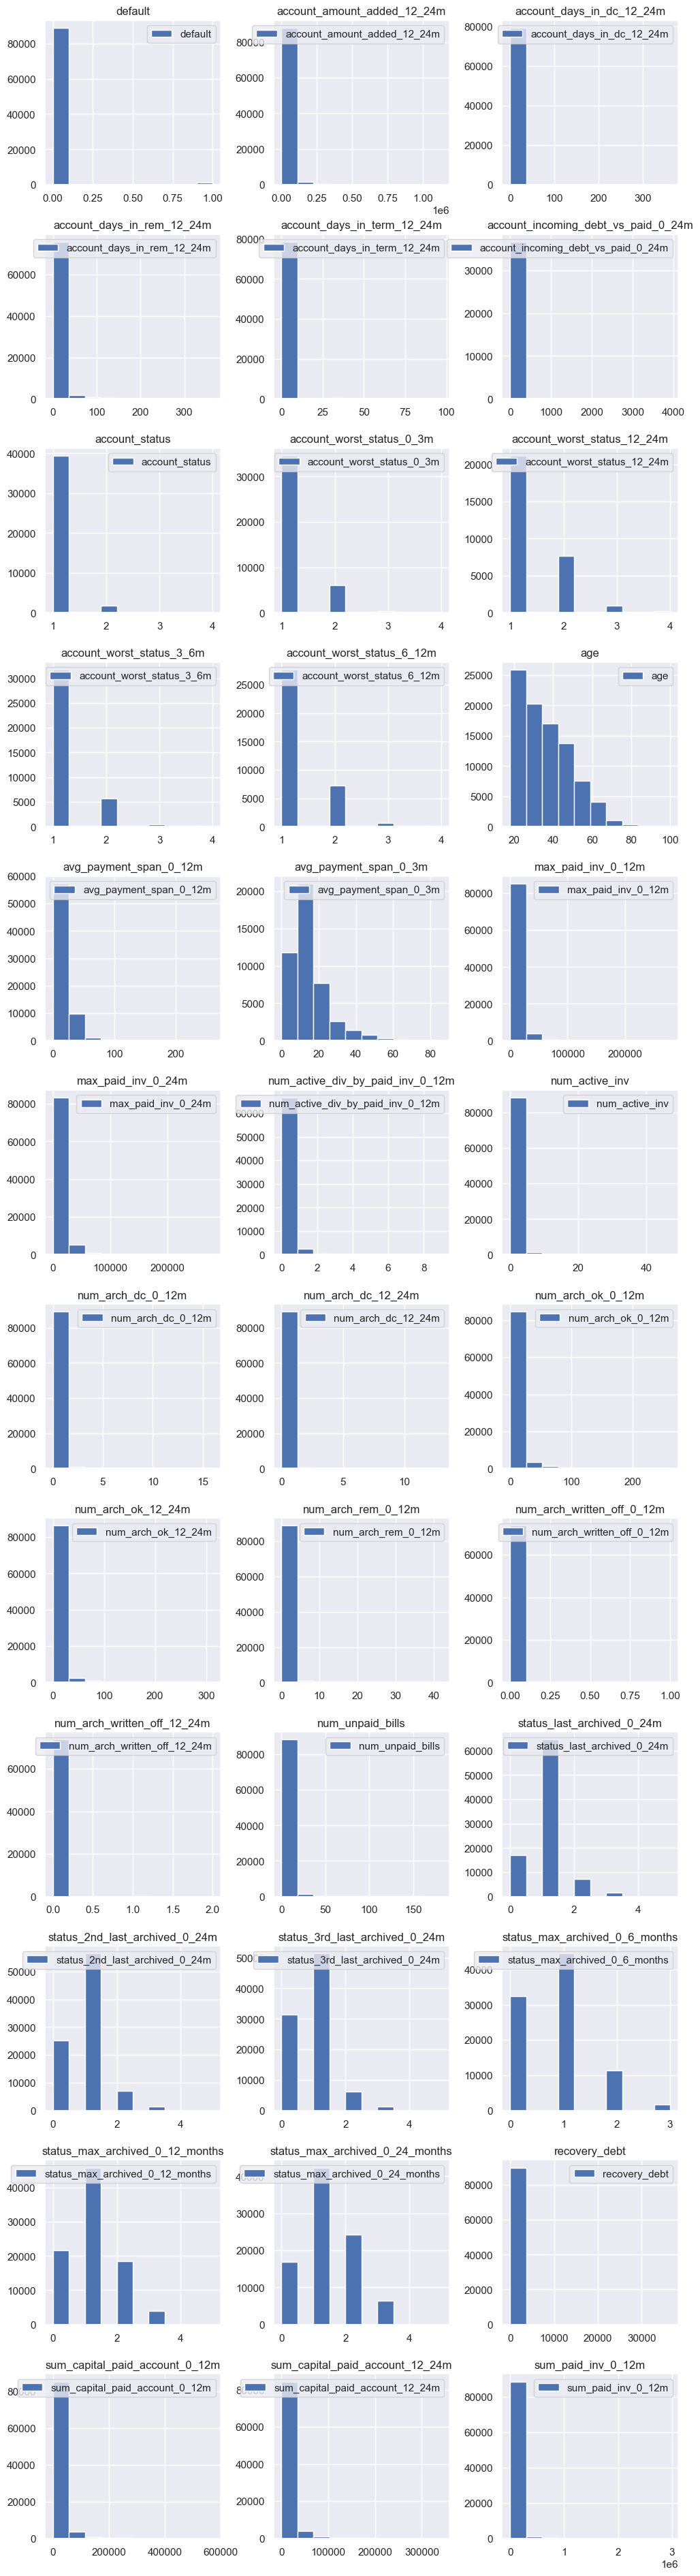

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)

temporary_train = train.select_dtypes(exclude=['O','bool'])
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)


k = 0
cols = temporary_train.columns



from itertools import combinations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(temporary_train.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        # temporary_train.hist(column = temporary_train.columns[i], bins = 100, ax=axis, legend = True)
        temporary_train.hist(column = temporary_train.columns[i],ax=axis, legend = True)
        i = i+1


<h2> Understanding Features </h2>


* Inorder to fill the missing values we need to understand the features and their distribution with regards to 'default', variable that we need to predict
<p>&nbsp;</p>

* we find categorical columns which also have missing values 
<p>&nbsp;</p>

In [52]:
categorical_columns = [
'account_status',
'account_worst_status_0_3m',
'account_worst_status_12_24m',
'account_worst_status_3_6m',
'account_worst_status_6_12m',
'merchant_category',
'merchant_group',
'name_in_email',
'status_last_archived_0_24m', 
'status_2nd_last_archived_0_24m', 
'status_3rd_last_archived_0_24m', 
'status_max_archived_0_6_months', 
'status_max_archived_0_12_months', 
'status_max_archived_0_24_months',
'worst_status_active_inv' ]

Columns_with_NaNs = [
'worst_status_active_inv',
'num_arch_written_off_12_24m',
'num_arch_written_off_0_12m',
'num_active_div_by_paid_inv_0_12m',
'avg_payment_span_0_3m',
'avg_payment_span_0_12m',
'account_worst_status_6_12m',
'account_worst_status_3_6m',
'account_worst_status_12_24m',
'account_worst_status_0_3m',
'account_status',
'account_incoming_debt_vs_paid_0_24m',
'account_days_in_term_12_24m',
'account_days_in_rem_12_24m',
'account_days_in_dc_12_24m'
]

cat_cols_that_have_Nans = set(categorical_columns).intersection( set(Columns_with_NaNs))
cat_cols_that_have_Nans = list(cat_cols_that_have_Nans)
print(cat_cols_that_have_Nans)

['account_status', 'account_worst_status_0_3m', 'account_worst_status_6_12m', 'account_worst_status_3_6m', 'account_worst_status_12_24m', 'worst_status_active_inv']


<h3> We will do a deep copy of train and call it 'data' and from now on do all operations on 'data'</h3> 

In [50]:
data = train.copy(deep=True)

<Axes: xlabel='worst_status_active_inv'>

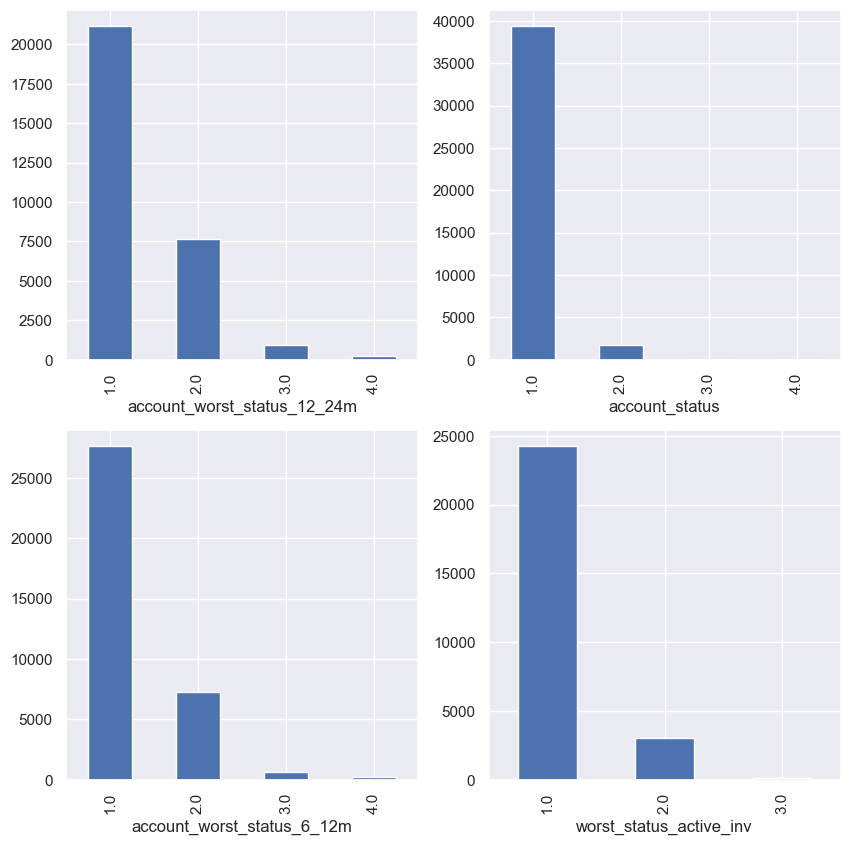

In [210]:
fig, ax = plt.subplots(2,2,figsize=(10, 10))

data[cat_cols_that_have_Nans[0]].value_counts().plot(ax=ax[0,0], kind='bar')
data[cat_cols_that_have_Nans[1]].value_counts().plot(ax=ax[0,1], kind='bar')
data[cat_cols_that_have_Nans[2]].value_counts().plot(ax=ax[1,0], kind='bar')
data[cat_cols_that_have_Nans[3]].value_counts().plot(ax=ax[1,1], kind='bar')




<Axes: xlabel='account_worst_status_0_3m'>

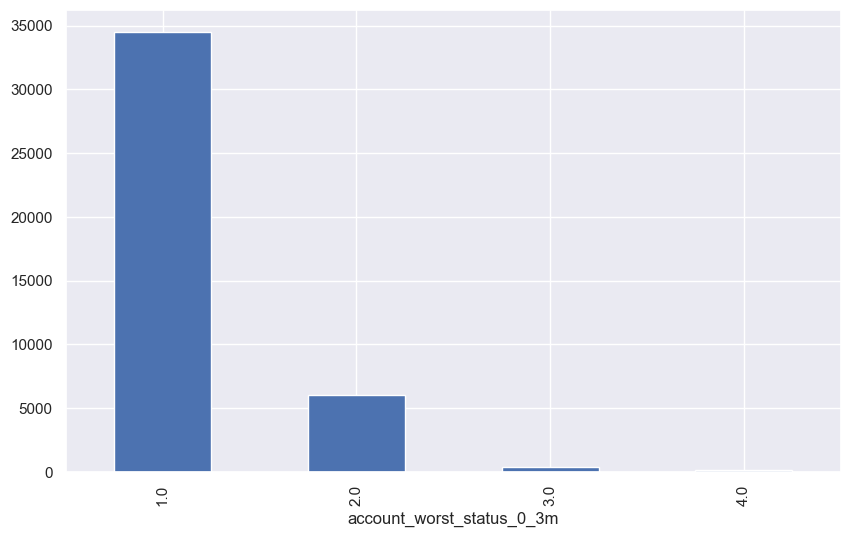

In [211]:
data[cat_cols_that_have_Nans[4]].value_counts().plot( kind='bar')

<Axes: xlabel='account_worst_status_3_6m'>

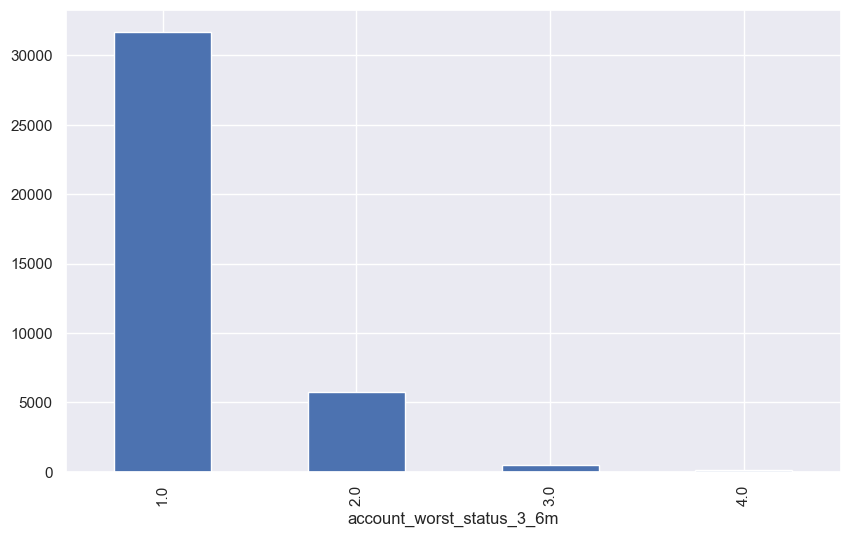

In [212]:
data[cat_cols_that_have_Nans[5]].value_counts().plot( kind='bar')

Observation: Overall we see that these 6 columns have maximum frequency as 1.0, and the order of frequency points also go by 1,2,3,4 and we must remember that this data is only based on few data points that we have as most data points are NaNs

<p>&nbsp;</p>

- account_worst_status_12_24m has 66% missing values
- account_status has 54% missing values
- account_worst_status_6_12m has 60% missing values
- account_worst_status_0_3m has 54% missing values
- account_worst_status_3_6m has 57% missing values
- worst_status_active_inv has  70% missing values
<p>&nbsp;</p>
Now we group them by default = 0  and default = 1 to observe the frequence

<Axes: xlabel='default,worst_status_active_inv'>

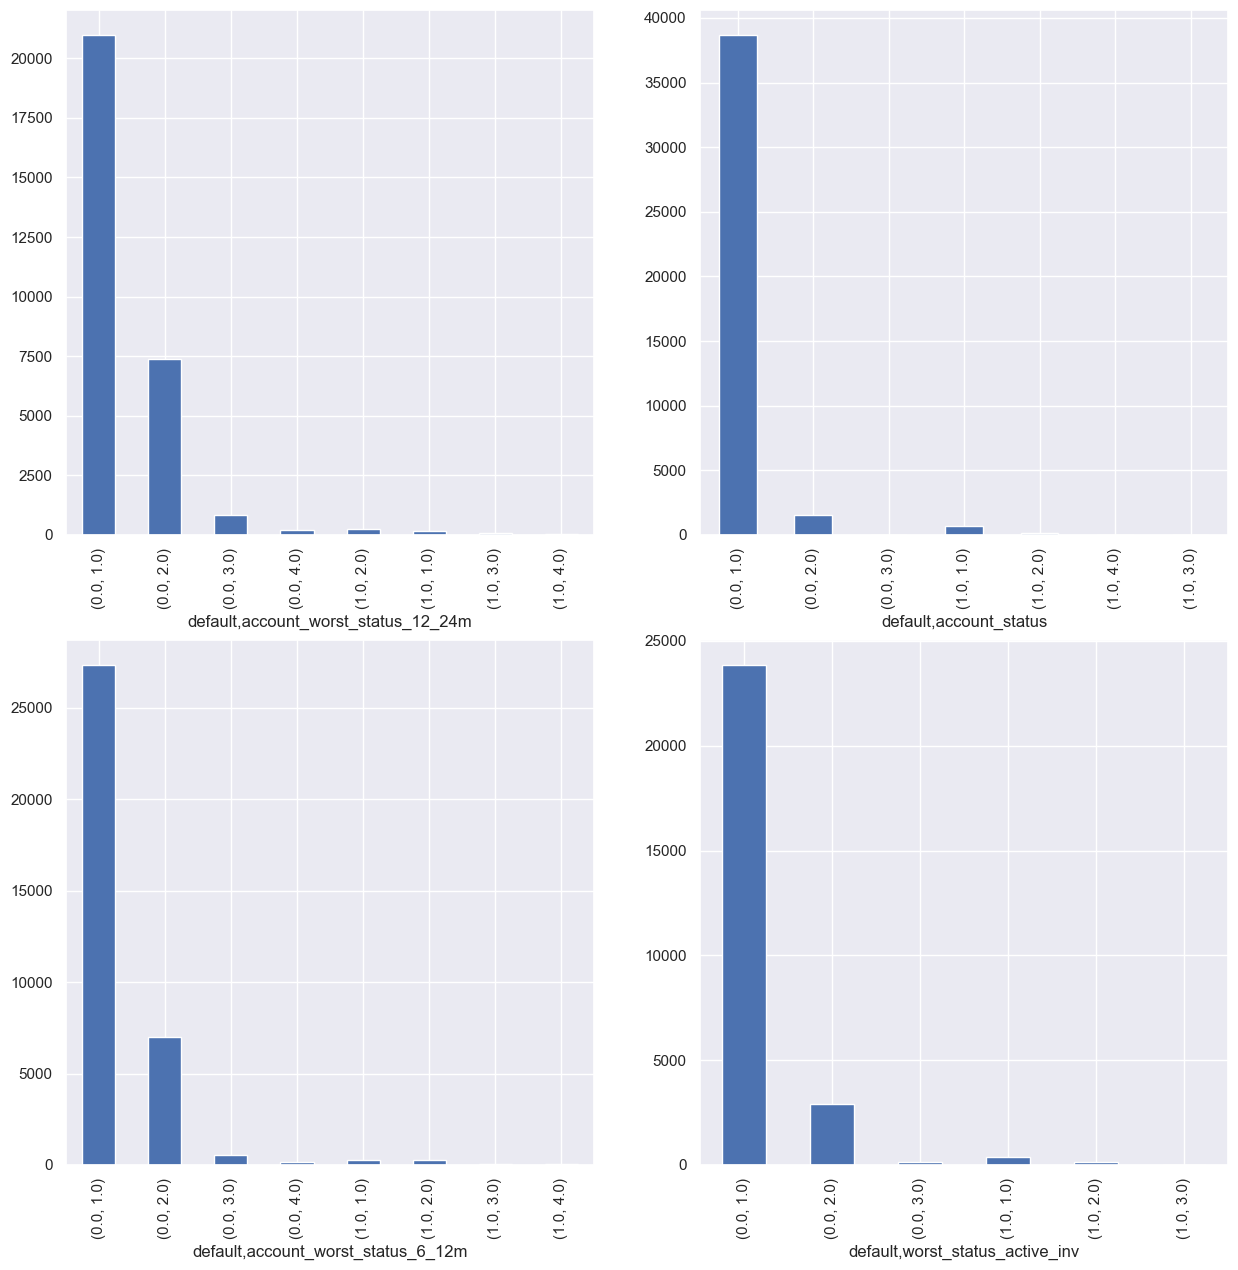

In [217]:
fig, ax = plt.subplots(2,2,figsize=(15, 15))
data.groupby('default')[cat_cols_that_have_Nans[0]].value_counts().plot(ax=ax[0,0], kind='bar')
data.groupby('default')[cat_cols_that_have_Nans[1]].value_counts().plot(ax=ax[0,1], kind='bar')
data.groupby('default')[cat_cols_that_have_Nans[2]].value_counts().plot(ax=ax[1,0], kind='bar')
data.groupby('default')[cat_cols_that_have_Nans[3]].value_counts().plot(ax=ax[1,1], kind='bar')


<Axes: xlabel='default,account_worst_status_0_3m'>

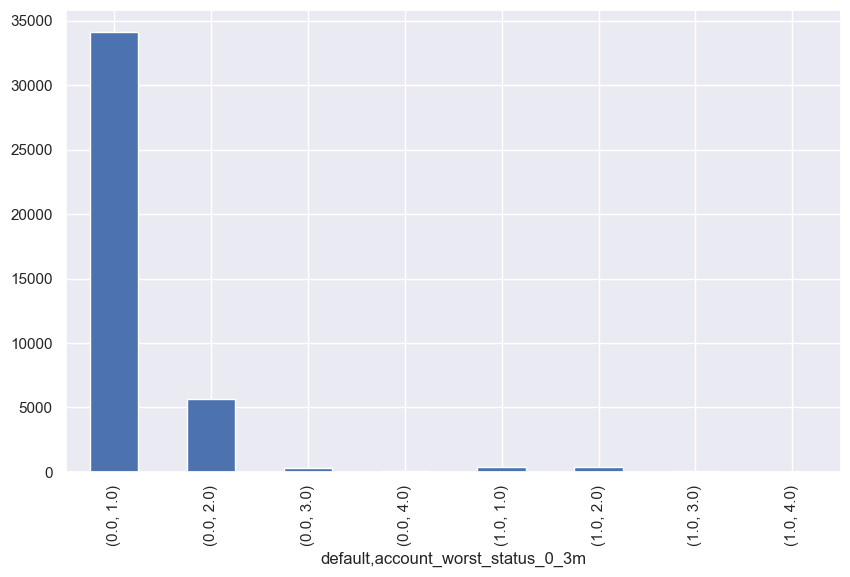

In [214]:
data.groupby('default')[cat_cols_that_have_Nans[4]].value_counts().plot(kind='bar')


<Axes: xlabel='default,account_worst_status_3_6m'>

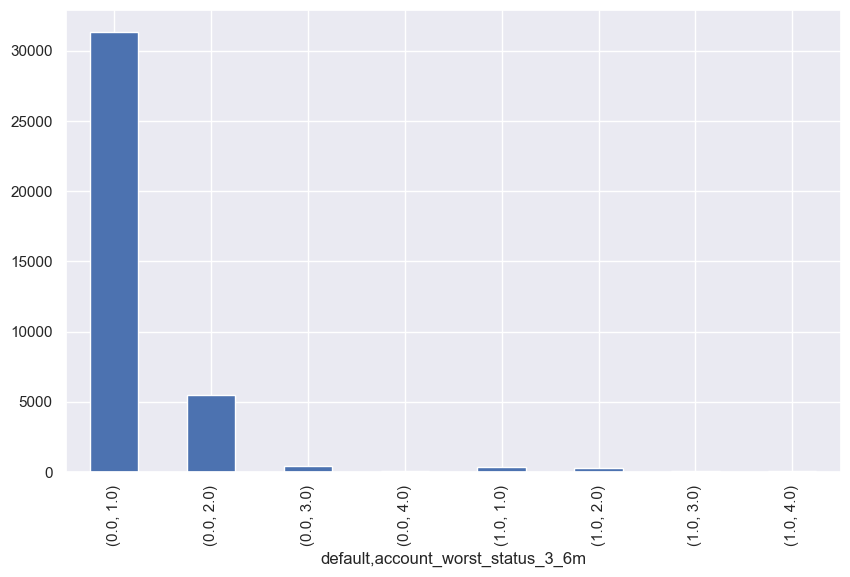

In [215]:
data.groupby('default')[cat_cols_that_have_Nans[5]].value_counts().plot(kind='bar')

Observation:
* The overall maximum frequency for every data point is 1.0, even though when it comes to default=1 in the case of "account_worst_status_12_24m" we have 2 as the highest frequency amongst group of default=1 but as far as our missing value substitution is concerned that should not affect.
<p>&nbsp;</p>

* As maximum records have 1.0, I think it is reasonable to substitute the NaN values for these 4 categories as the mode or highest frequency data point which is 1.0 for the respective columns as it would be the representative of the data
<p>&nbsp;</p>

<h2> Filling NaN values </h2> 

In [53]:
data[cat_cols_that_have_Nans].mode()

,account_status,account_worst_status_0_3m,account_worst_status_6_12m,account_worst_status_3_6m,account_worst_status_12_24m,worst_status_active_inv
0,1.0,1.0,1.0,1.0,1.0,1.0


In [54]:
data[cat_cols_that_have_Nans] = data.loc[:,cat_cols_that_have_Nans].fillna(value=1.0)

<h3> For the other missing values </h3>

The other missing values here are columns which are numeric and continuous

In [55]:
other_cols = set(Columns_with_NaNs) - set(cat_cols_that_have_Nans)
other_cols = list(other_cols)

<h4> Looking at the value_counts for several columns, we find that mode and frequency of that mode in total data  </h4>

* The strategy is to find the frequency of this mode as a percent of total data in that column for instance for the column 'account_days_in_dc_12_24m' has 0.0 as 88% of its data points therefore in this case we will impute the NaN with mode which is 0.0




* We find that for columns 'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m','num_arch_written_off_12_24m', 'account_days_in_term_12_24m', 'num_arch_written_off_0_12m',the mode represents: 87%, 78% , 81.8%, 87% and 82%  of the dataset for these columns respectively therefore we impute these columns with their respective modes.

In [222]:
for i in range(9):
    if i==5:
        continue
    print(f" mode for the column {other_cols[i]}: {data[other_cols[i]].mode()}", )
    mode_count_percent = (data[other_cols[i]].value_counts()[0]/len(data[other_cols[i]]))*100
    print("percentage of total data in that column", mode_count_percent)
    print()



 mode for the column account_days_in_dc_12_24m: 0    0.0
Name: account_days_in_dc_12_24m, dtype: float64
percentage of total data in that column 87.86898728549836

 mode for the column avg_payment_span_0_3m: 0    14.0
Name: avg_payment_span_0_3m, dtype: float64
percentage of total data in that column 0.8102160576153641

 mode for the column account_incoming_debt_vs_paid_0_24m: 0    0.0
Name: account_incoming_debt_vs_paid_0_24m, dtype: float64
percentage of total data in that column 13.070152040544144

 mode for the column account_days_in_rem_12_24m: 0    0.0
Name: account_days_in_rem_12_24m, dtype: float64
percentage of total data in that column 78.43758335556149

 mode for the column num_arch_written_off_12_24m: 0    0.0
Name: num_arch_written_off_12_24m, dtype: float64
percentage of total data in that column 81.86849826620433

 mode for the column avg_payment_span_0_12m: 0    14.0
Name: avg_payment_span_0_12m, dtype: float64
percentage of total data in that column 0.5101360362763404


In [56]:
cols_to_impute_by_mode = ['account_days_in_dc_12_24m',
                        'account_days_in_rem_12_24m',
                        'num_arch_written_off_12_24m',
                        'account_days_in_term_12_24m',
                        'num_arch_written_off_0_12m']

data[cols_to_impute_by_mode].mode()

,account_days_in_dc_12_24m,account_days_in_rem_12_24m,num_arch_written_off_12_24m,account_days_in_term_12_24m,num_arch_written_off_0_12m
0,0.0,0.0,0.0,0.0,0.0


In [57]:
data[cols_to_impute_by_mode] = data.loc[:,cols_to_impute_by_mode].fillna(value=0.0)

<h4> now we are left with 4 columns for imputation </h4>


In [58]:
numerical_cols_left = set(other_cols) - set(cols_to_impute_by_mode)

<Axes: >

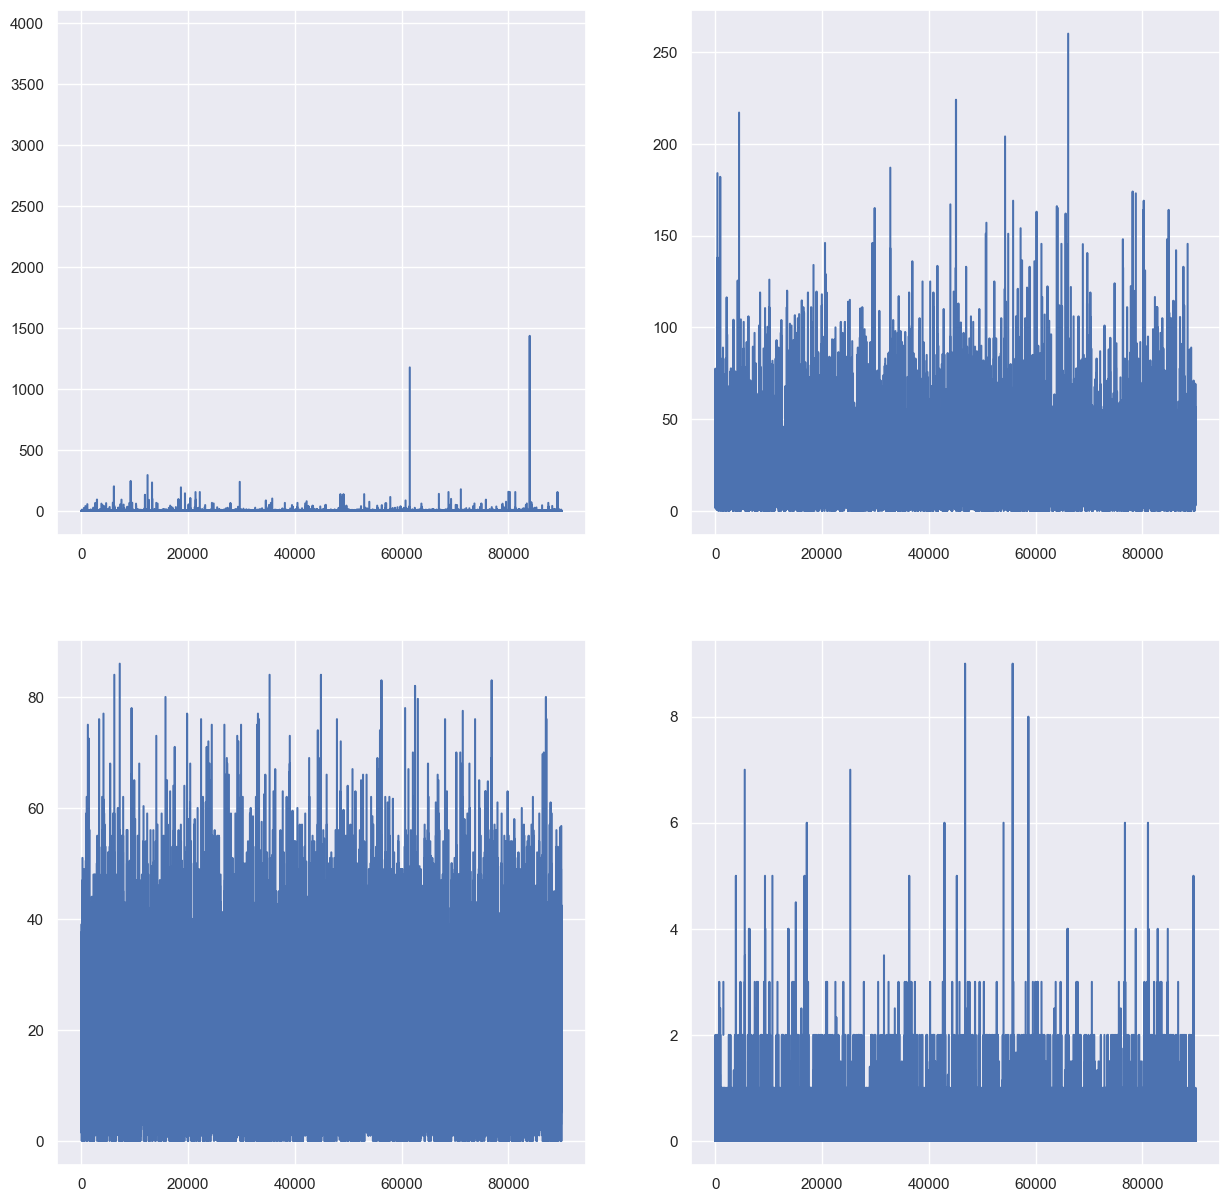

In [234]:
fig, ax = plt.subplots(2,2,figsize=(15, 15))
data['account_incoming_debt_vs_paid_0_24m'].plot(ax=ax[0,0])
data['avg_payment_span_0_12m'].plot(ax=ax[0,1])
data['avg_payment_span_0_3m'].plot(ax=ax[1,0])
data['num_active_div_by_paid_inv_0_12m'].plot(ax=ax[1,1])

<h3>Fill the NaNs for the above 4 columns by choosing their column mean </h3>

In [59]:


for col in numerical_cols_left:
    data[col] = data.loc[:,col].fillna(value=data[col].mean())


In [60]:
data[list(numerical_cols_left)].mean()

account_incoming_debt_vs_paid_0_24m     1.330536
num_active_div_by_paid_inv_0_12m        0.114667
avg_payment_span_0_12m                 17.977933
avg_payment_span_0_3m                  14.960416
dtype: float64

<h3>Label Encoding and One Hot Encoding for Categorical Features </h3>


* Strategy 1


    * For categorical features where the number of unique values is less than or equal to 5 we choose LabelEncoding and for features with more than 5 unique values we will go for one hot encoding, for implementation I will choose pd.get_dummies because the column naming is really good and then drop the column after merging.

    * Pros of strategy 1:
        * Dimensionality reduction
    * Cons of Strategy 1:
        * Label encoding can bring inherent bias for some features

* Strategy 2

    * For all categorical features do one hot encoding

        Dummy variables can have two problems Multicollinearity, and Mismatched columns between train and data sets, Both are taken care of.


    * Pros: No bias in categorical variables for ML algorithm

    * Cons: Dimensionality explosion problems.



In [310]:
sum_total = 0
for col in categorical_columns:
    print(col, 'total_unique_values:', len(data[col].unique()))
    print(data[col].unique())
    print()
    sum_total += len(data[col].unique())
print(sum_total)

account_status total_unique_values: 4
[1. 2. 3. 4.]

account_worst_status_0_3m total_unique_values: 4
[1. 2. 3. 4.]

account_worst_status_12_24m total_unique_values: 4
[1. 2. 3. 4.]

account_worst_status_3_6m total_unique_values: 4
[1. 2. 3. 4.]

account_worst_status_6_12m total_unique_values: 4
[1. 3. 2. 4.]

merchant_category total_unique_values: 57
['Dietary supplements' 'Books & Magazines' 'Diversified entertainment'
 'Electronic equipment & Related accessories'
 'Concept stores & Miscellaneous' 'Youthful Shoes & Clothing'
 'General Shoes & Clothing' 'Prints & Photos'
 'Diversified children products' 'Pet supplies'
 'Diversified Home & Garden products' 'Sports gear & Outdoor'
 'Diversified electronics' 'Diversified Jewelry & Accessories'
 'Travel services' 'Prescription optics' 'Pharmaceutical products'
 'Dating services' 'Diversified Health & Beauty products' 'Children toys'
 'Automotive Parts & Accessories' 'Jewelry & Watches' 'Digital services'
 'Decoration & Art' 'Children Clot

<h4> 'data' has no missing values, creating s_1_df as deep copy of data to have further operations on 1st strategy and similarly s_2_df for 2nd strategy as given below</h4>

In [13]:
s_1_df = data.copy(deep=True)


<h3> Strategy 1 </h3>

* Label encoding for categorial features with unique values less than equal to 5
* One hot encoding for categorial features with unique values more than 5

In [12]:
cols_for_Label_encoding = []
cols_for_one_hot_encoding = []

for col in categorical_columns:
    if col == 'default':
        continue
    if len(data[col].unique()) > 5:
        cols_for_one_hot_encoding.append(col)
    else:
        cols_for_Label_encoding.append(col)

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in cols_for_Label_encoding:
    s_1_df[feat] = le.fit_transform(s_1_df[feat].astype(str))

In [14]:
s_1_df = pd.get_dummies(s_1_df, columns=cols_for_one_hot_encoding)

In [17]:
sum_total_cols_after_one_hot = 0

for col in cols_for_one_hot_encoding:
    sum_total_cols_after_one_hot += len(data[col].unique())
print(sum_total_cols_after_one_hot)

77


In [18]:
# Verigy number of columns for strategy 1 when only few cat cols will be dummy encoded
num_of_cols = len(data.columns) - len(cols_for_one_hot_encoding)  + sum_total_cols_after_one_hot
assert(s_1_df.shape[1] == num_of_cols)

<h3> Strategy 2</h3>

* Convert all Categorical columns in one-hot encoding (when it comes to algorithms such XG boost strategy 2 must be preferred)

In [74]:
s_2_df = data.copy(deep=True)

In [75]:
s_2_df.shape

(89976, 43)

# Feature Exploration

<h2> Shapely Additive Explanations (ShAP) </h2> 
<h4> code found in another notebook</h4>

# Default Estimation using XGBoost


* As training with all features is taking a lot of time for the purpose of this assignment I am going to do dimensionality reduction and remove some features

* First XGBOOST Model Attempt: 
    * I am going to choose randomly 5 categories with less than 5 unique values just to save time in training and top 5 numerical columns from shapely Additive Analysis (other notebook), I know there are several assumptions here, but this is just to reduce training time





In [76]:
categories_with_less_than_5_unique_values = []
for col in categorical_columns:
    if  len(data[col].unique()) < 5:
        categories_with_less_than_5_unique_values.append(col)
    


top_5_numerical_cols_from_shap = ['num_arch_ok_0_12m', 'num_unpaid_bills', 'avg_payment_span_0_12m','age','max_paid_inv_0_24m']


total_cols_to_consider = top_5_numerical_cols_from_shap[:5] + categories_with_less_than_5_unique_values[:5]

print(total_cols_to_consider)

['num_arch_ok_0_12m', 'num_unpaid_bills', 'avg_payment_span_0_12m', 'age', 'max_paid_inv_0_24m', 'account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m', 'account_worst_status_3_6m', 'account_worst_status_6_12m']


In [77]:
# preparing for training

default_ = s_2_df['default']

# only training columns selected
s_2_df = s_2_df[total_cols_to_consider]

dummy = pd.get_dummies(s_2_df, columns = categories_with_less_than_5_unique_values[:5])


In [100]:
dummy.shape

(89976, 25)

In [29]:
len(s_2_df.columns) == len(total_cols_to_consider)

True

In [30]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN 
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score


# scale the data
scaler = StandardScaler()
scaled_dummy = scaler.fit_transform(dummy)

X = scaled_dummy
y = default_

X_train, X_test, y_train, y_test = train_test_split(X.astype(float), y.astype(float),
                                                             test_size=0.2,
                                                             random_state=42)




smote = SMOTEENN(random_state = 2) 
X_train, y_train = smote.fit_resample(X_train, y_train.ravel())


xgb = XGBClassifier(random_state = 12345)

xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 1],
    "min_samples_split": np.linspace(0.1, 0.5, 10),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.9, 1.0],
    "n_estimators": [10]}

xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X_train,y_train ) 



Fitting 10 folds for each of 360 candidates, totalling 3600 fits
[16:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



In [31]:
xgb_tuned = XGBClassifier(**xgb_cv_model.best_params_).fit(X_train,y_train)
cross_val_score(xgb_tuned, X_train, y_train, cv = 10).mean()


[17:31:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[17:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[17:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[17:31:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[17:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "m

0.9853455617607771

0.8090117425543554


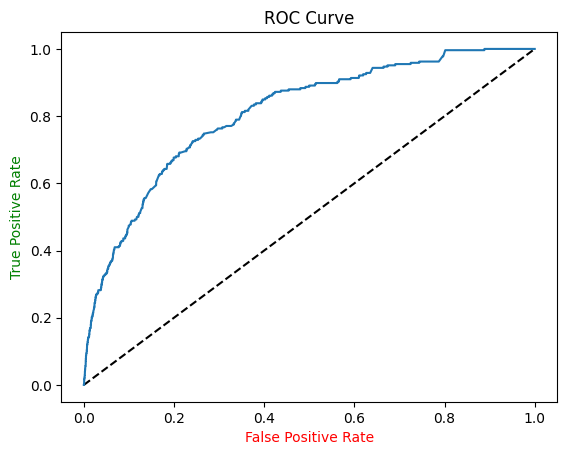

In [32]:
#Predicting proba
y_pred_prob = xgb_tuned.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', color="r")
plt.ylabel('True Positive Rate', color="g")
plt.title('ROC Curve')
print(roc_auc_score(y_test, y_pred_prob))
plt.show()

In [33]:
xgb_tuned.save_model("model_with_5_cat_5_num_81_percent.json")

<h3>Combining all above operations into single function for testing </h3>

* Input will be a json file and trained model and output will be ['uuid', 'default']

### Operations on test dataset

(Fill by mode the above are category cols with NaNs)

account_worst_status_12_24m
account_status
account_worst_status_6_12m
worst_status_active_inv	account_worst_status_0_3m
account_worst_status_3_6m
worst_status_active_inv


 

Fill by mean

account_incoming_debt_vs_paid_0_24m
avg_payment_span_0_12m
avg_payment_span_0_3m
num_active_div_by_paid_inv_0_12m


Fill by mode

'account_days_in_dc_12_24m',
'account_days_in_rem_12_24m',
'num_arch_written_off_12_24m',
'account_days_in_term_12_24m',
 'num_arch_written_off_0_12m'


Remember to use this when doing test dataset operations
> X_test = pd.get_dummies(df_test)

>X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

In [80]:
import json
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN 
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('C:\Tests\Klarna\klarna\dataset.csv', sep=';')
test = df[df['default'].isna()]

test_in_json = test.to_json()
input_file = test_in_json
model_path = 'C:\Tests\Klarna\klarna\Scripts\model_with_5_cat_5_num_81_percent.json'


model_xgb = XGBClassifier()
model_xgb.load_model(model_path)
# Use pandas.DataFrame.from_dict() to Convert JSON to DataFrame
d = json.loads(input_file)
test_df = pd.DataFrame.from_dict(d)

test_uuid_ = test_df['uuid']

top_5_categories_with_less_than_5_unique_values = ['account_status',\
 'account_worst_status_0_3m','account_worst_status_12_24m',\
 'account_worst_status_3_6m','account_worst_status_6_12m']

total_cols_to_consider = ['num_arch_ok_0_12m', 'num_unpaid_bills',\
                         'avg_payment_span_0_12m', 'age', 'max_paid_inv_0_24m',\
                         'account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m',\
                         'account_worst_status_3_6m', 'account_worst_status_6_12m']
# for empty fields I am assuming that data like training data, so the NaN fieldS which were empty in training data
# can be filled in test data but some other fields should be compulsary

d = {'avg_payment_span_0_12m':17.977933,'account_status':1.0,'account_worst_status_0_3m':1.0,
'account_worst_status_12_24m':1.0,'account_worst_status_3_6m':1.0,'account_worst_status_6_12m':1.0}

# 'num_arch_ok_0_12m', 'num_unpaid_bills','age', 'num_arch_ok_0_12m' should be compulsary (these are amendable based on requirements)

for col in total_cols_to_consider:
    if col in d.keys():
        test_df[col] = test_df[col].fillna(d[col])

test_df = test_df[total_cols_to_consider]

X_test = pd.get_dummies(test_df, columns = top_5_categories_with_less_than_5_unique_values)

train_dummy_cols = ['num_arch_ok_0_12m', 'num_unpaid_bills', 'avg_payment_span_0_12m',\
    'age', 'max_paid_inv_0_24m', 'account_status_1.0', 'account_status_2.0',\
    'account_status_3.0', 'account_status_4.0',\
    'account_worst_status_0_3m_1.0', 'account_worst_status_0_3m_2.0',\
    'account_worst_status_0_3m_3.0', 'account_worst_status_0_3m_4.0',\
    'account_worst_status_12_24m_1.0', 'account_worst_status_12_24m_2.0',\
    'account_worst_status_12_24m_3.0', 'account_worst_status_12_24m_4.0',\
    'account_worst_status_3_6m_1.0', 'account_worst_status_3_6m_2.0',\
    'account_worst_status_3_6m_3.0', 'account_worst_status_3_6m_4.0',\
    'account_worst_status_6_12m_1.0', 'account_worst_status_6_12m_2.0',\
    'account_worst_status_6_12m_3.0', 'account_worst_status_6_12m_4.0']


X_test = X_test.reindex(columns = train_dummy_cols, fill_value=0)

# scale the test data
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

results = model_xgb.predict_proba(X_test_scaled)[:,1]

results_d = pd.DataFrame({'uuid':test_uuid_,'default':results})


results_d.to_json


<bound method NDFrame.to_json of                                        uuid   default
89976  6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7  0.999831
89977  f6f6d9f3-ef2b-4329-a388-c6a687f27e70  0.982638
89978  e9c39869-1bc5-4375-b627-a2df70b445ea  0.999484
89979  6beb88a3-9641-4381-beb6-c9a208664dd0  0.993055
89980  bb89b735-72fe-42a4-ba06-d63be0f4ca36  0.826725
...                                     ...       ...
99971  5c03bc63-ea65-4ffd-aa7b-95ea9a46db34  0.002875
99972  f8db22f4-9819-420c-abbc-9ddf1843176e  0.999244
99973  b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8  0.993849
99974  bafcab15-9898-479c-b729-c9dda7edb78f  0.999376
99975  ac88f18c-96a6-49bc-9e9d-a780225914af  0.999365

[10000 rows x 2 columns]>

In [15]:
import pickle
pickle.dump(model_xgb,open('xgb_5_cat_5_num.pkl','wb'))

In [37]:
model_xgb_pickled = pickle.load(open('xgb_5_cat_5_num.pkl','rb'))

<h4>Combining everything above in single code to build Flask App </h4>

In [4]:

df = pd.read_csv('C:\Tests\Klarna\klarna\dataset.csv', sep=';')
test = df[df['default'].isna()]

test_in_json = test.to_json()
input_file = test_in_json
model_path = 'C:\Tests\Klarna\klarna\Scripts\model_with_5_cat_5_num_81_percent.json'

def testing(input_file = test_in_json, model_path = 'C:\Tests\Klarna\klarna\Scripts\model_with_5_cat_5_num_81_percent.json'):

    model_xgb = XGBClassifier()
    model_xgb.load_model(model_path)
    # Use pandas.DataFrame.from_dict() to Convert JSON to DataFrame
    d = json.loads(input_file)
    test_df = pd.DataFrame.from_dict(d)

    test_uuid_ = test_df['uuid']

    top_5_categories_with_less_than_5_unique_values = ['account_status',\
    'account_worst_status_0_3m','account_worst_status_12_24m',\
    'account_worst_status_3_6m','account_worst_status_6_12m']

    total_cols_to_consider = ['num_arch_ok_0_12m', 'num_unpaid_bills',\
                            'avg_payment_span_0_12m', 'age', 'max_paid_inv_0_24m',\
                            'account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m',\
                            'account_worst_status_3_6m', 'account_worst_status_6_12m']
    # for empty fields I am assuming that data like training data, so the NaN fieldS which were empty in training data
    # can be filled in test data but some other fields should be compulsary

    d = {'avg_payment_span_0_12m':17.977933,'account_status':1.0,'account_worst_status_0_3m':1.0,
    'account_worst_status_12_24m':1.0,'account_worst_status_3_6m':1.0,'account_worst_status_6_12m':1.0}

    # 'num_arch_ok_0_12m', 'num_unpaid_bills','age', 'num_arch_ok_0_12m' should be compulsary (these are amendable based on requirements)

    for col in total_cols_to_consider:
        if col in d.keys():
            test_df[col] = test_df[col].fillna(d[col])

    test_df = test_df[total_cols_to_consider]

    X_test = pd.get_dummies(test_df, columns = top_5_categories_with_less_than_5_unique_values)

    train_dummy_cols = ['num_arch_ok_0_12m', 'num_unpaid_bills', 'avg_payment_span_0_12m',\
        'age', 'max_paid_inv_0_24m', 'account_status_1.0', 'account_status_2.0',\
        'account_status_3.0', 'account_status_4.0',\
        'account_worst_status_0_3m_1.0', 'account_worst_status_0_3m_2.0',\
        'account_worst_status_0_3m_3.0', 'account_worst_status_0_3m_4.0',\
        'account_worst_status_12_24m_1.0', 'account_worst_status_12_24m_2.0',\
        'account_worst_status_12_24m_3.0', 'account_worst_status_12_24m_4.0',\
        'account_worst_status_3_6m_1.0', 'account_worst_status_3_6m_2.0',\
        'account_worst_status_3_6m_3.0', 'account_worst_status_3_6m_4.0',\
        'account_worst_status_6_12m_1.0', 'account_worst_status_6_12m_2.0',\
        'account_worst_status_6_12m_3.0', 'account_worst_status_6_12m_4.0']


    X_test = X_test.reindex(columns = train_dummy_cols, fill_value=0)

    # scale the test data
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)

    results = model_xgb.predict_proba(X_test_scaled)[:,1]

    results_d = pd.DataFrame({'uuid':test_uuid_,'default':results})


    # return results_d.to_json
    return results_d
    
testing(input_file,model_path)


,uuid,default
89976,6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,0.999831
89977,f6f6d9f3-ef2b-4329-a388-c6a687f27e70,0.982638
89978,e9c39869-1bc5-4375-b627-a2df70b445ea,0.999484
89979,6beb88a3-9641-4381-beb6-c9a208664dd0,0.993055
89980,bb89b735-72fe-42a4-ba06-d63be0f4ca36,0.826725
...,...,...
99971,5c03bc63-ea65-4ffd-aa7b-95ea9a46db34,0.002875
99972,f8db22f4-9819-420c-abbc-9ddf1843176e,0.999244
99973,b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8,0.993849
99974,bafcab15-9898-479c-b729-c9dda7edb78f,0.999376
